## Naive_bayes_sms_classification


## Import Required Libraries


In [59]:
import pandas as pd
import numpy as np
import string 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from  wordcloud import WordCloud

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
import joblib
warnings.filterwarnings('ignore')

In [23]:
#Import The dataset
df=pd.read_csv("D:\sms_spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Cleaning $ EDA Perform

In [25]:
#Remove unnecessoary columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [26]:
# Rename of columns
df.rename(columns={'v1':'label','v2':'text'},inplace=True)

In [27]:
# Check the Null values in dataset
df.isnull().sum()

label    0
text     0
dtype: int64

In [28]:
#remove duplicates data
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

403


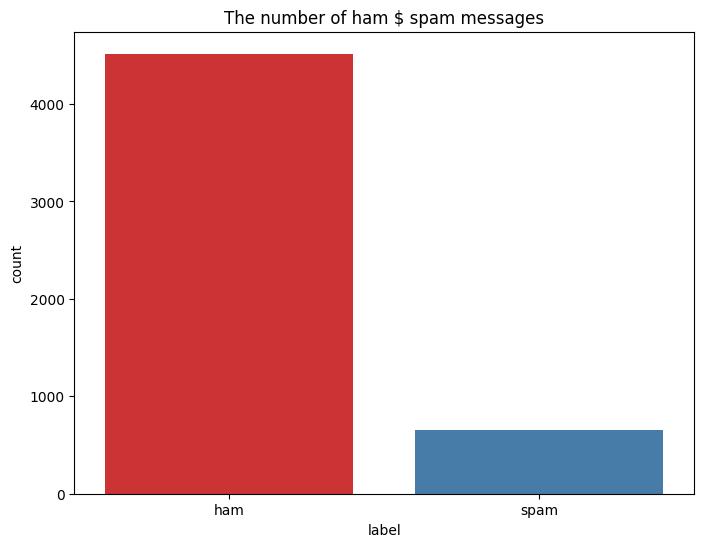

In [29]:
#plot the number of spam and ham message
plt.figure(figsize=(8,6))
sns.countplot(data=df,x='label',palette='Set1')
plt.title("The number of ham $ spam messages")

plt.show()


In [30]:
#Plot Number of Charecter,words and sentence of Spam and Ham Messages
df['mum_charecters']=df['text'].apply(len)

df['num_sent']=df['text'].apply(sent_tokenize)
df['num_sent']=df['num_sent'].apply(len)

df['num_word']=df['text'].apply(word_tokenize)
df['num_word']=df['num_word'].apply(len)

<Figure size 1200x600 with 0 Axes>

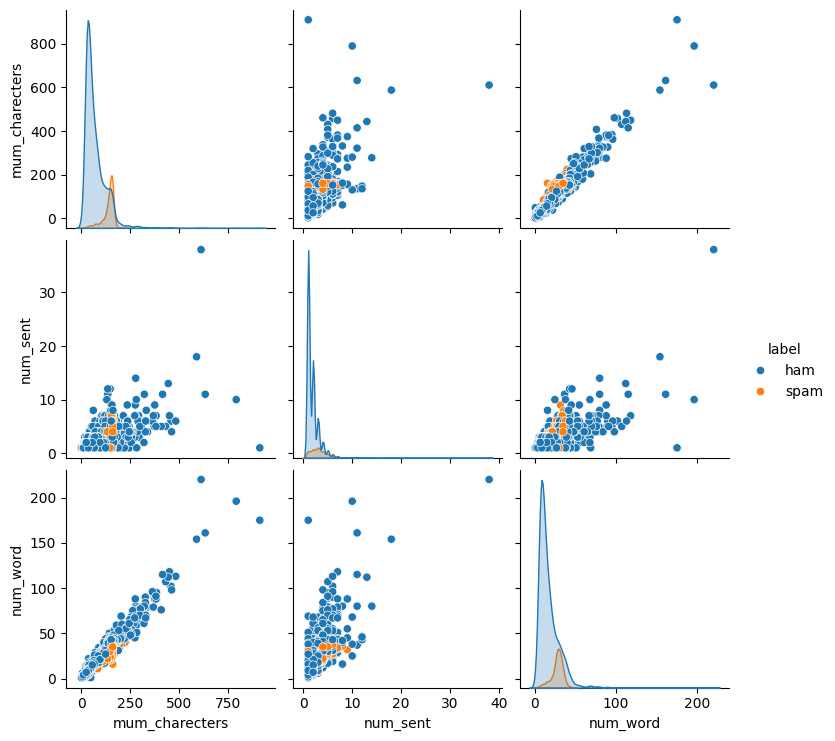

In [31]:
plt.figure(figsize=(12,6))
sns.pairplot(df,hue='label')
plt.show()

## Feature Engineering

In [32]:
#Label Encoding for  Spam=0 and Ham=1
label_encode=LabelEncoder()
df['label']=label_encode.fit_transform(df['label'])

#Display the Updated DataFrame
df

,label,text,mum_charecters,num_sent,num_word
0,0,"Go until jurong point, crazy.. Available only ...",111,2,24
1,0,Ok lar... Joking wif u oni...,29,2,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,37
3,0,U dun say so early hor... U c already then say...,49,1,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1,15
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,4,35
5568,0,Will Ì_ b going to esplanade fr home?,37,1,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,2,15
5570,0,The guy did some bitching but I acted like i'd...,125,1,27


In [33]:
#Text Lower caseing
df['text']=df['text'].str.lower()

In [34]:
#Remove Punctuations
punc=string.punctuation
def remove_punctuation(txt):
    clean_word=''.join([word for word in txt if word not in punc])
    return clean_word

df['text']=df['text'].apply(lambda x:remove_punctuation(x))

In [35]:
#Remove HTML Tags
def remove_html(txt):
    clean_txt=re.sub(r'\d+',' ',txt)
    return clean_txt

df['text']=df['text'].apply(remove_html)

In [36]:
#Tokenizing the text into word
df['text']=df['text'].apply(word_tokenize)

In [37]:
df

,label,text,mum_charecters,num_sent,num_word
0,0,"[go, until, jurong, point, crazy, available, o...",111,2,24
1,0,"[ok, lar, joking, wif, u, oni]",29,2,8
2,1,"[free, entry, in, a, wkly, comp, to, win, fa, ...",155,2,37
3,0,"[u, dun, say, so, early, hor, u, c, already, t...",49,1,13
4,0,"[nah, i, dont, think, he, goes, to, usf, he, l...",61,1,15
...,...,...,...,...,...
5567,1,"[this, is, the, nd, time, we, have, tried, con...",161,4,35
5568,0,"[will, ì, b, going, to, esplanade, fr, home]",37,1,9
5569,0,"[pity, was, in, mood, for, that, soany, other,...",57,2,15
5570,0,"[the, guy, did, some, bitching, but, i, acted,...",125,1,27


In [38]:
#Remove Stopwords
sw=stopwords.words('english')
def remove_stopword(txt):
    cln_word=[word for word in txt if word not in sw]
    return cln_word

df['text']=df['text'].apply(lambda x:remove_stopword(x))

In [45]:
#seperate the Messages words based on Categories
ham_words=df[df['label']==0]['text']
spam_words=df[df['label']==1]['text']

#Combine Messages  into a Single list
ham_messages=[]
for word in ham_words:
    ham_messages.append(' '.join(word))

spam_messages=[]
for word in spam_words:
    spam_messages.append(' '.join(word))

#combine messages list to a Single String
ham_messages=' '.join(ham_messages)
spam_messages=' '.join(spam_messages)


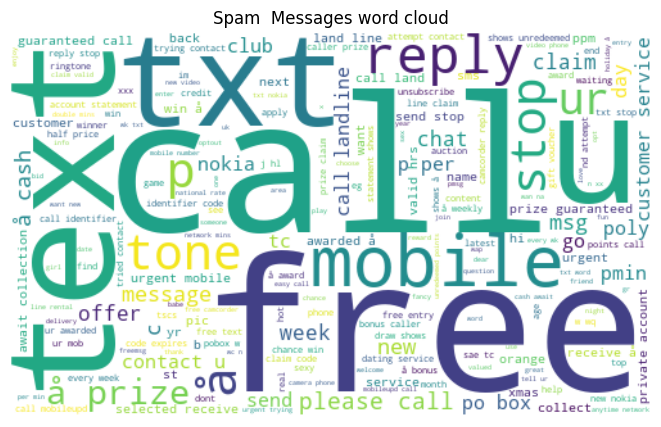

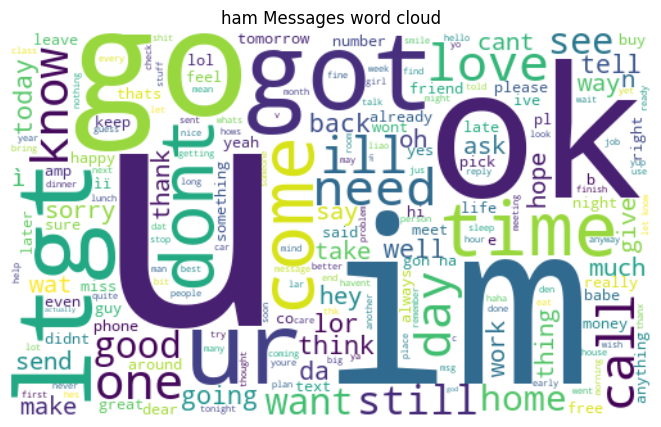

In [46]:
#Create a Word Cloud for Spam messages
spam_wc=WordCloud(width=500,height=300,background_color='white')
spam_wc.generate(spam_messages)
plt.figure(figsize=(10,5))
plt.imshow(spam_wc,interpolation='bilinear')
plt.title("Spam  Messages word cloud")
plt.axis('off')
plt.show()
 
#Create a Word cloud for Ham Messages
ham_wc=WordCloud(width=500,height=300,background_color='white')
ham_wc.generate(ham_messages)
plt.figure(figsize=(10,5))
plt.imshow(ham_wc,interpolation='bilinear')
plt.title("ham Messages word cloud")
plt.axis('off')
plt.show;

In [47]:
#Lemmatization words  
lemma=WordNetLemmatizer()
def word_lemmatize(txt):
    lemma_word=[lemma.lemmatize(word) for word in txt]
    return lemma_word


df['text']=df['text'].apply(lambda x:word_lemmatize(x))

In [48]:
### Text Vectorization Using TF-IDf

In [50]:
#Joint All Tokens into a Single List
corpus=[' '.join (tokens) for tokens in df.text]

tfidf=TfidfVectorizer()
vector_data=tfidf.fit_transform(corpus)
#Convert into a Array
vector_data=vector_data.toarray()
vector_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5169, 7859))

## Train_test_split data

In [52]:
#Creating Dependent and Independent Variable
x=df['text']
y=df['label']

In [53]:
#Train Test Split,use 80% train,and 20% test
x_train,x_test,y_train,y_test=train_test_split(vector_data,y,test_size=0.2,random_state=42)

In [54]:
#see the Shape of x_train,X_test,y_train,Y_test:
print("x_train shape =",(x_train.shape))
print("x_test shape =",(x_test.shape))
print("y_train shape =",(y_train.shape))
print("y_test shape =",(y_test.shape))

x_train shape = (4135, 7859)
x_test shape = (1034, 7859)
y_train shape = (4135,)
y_test shape = (1034,)


## Model Building

In [55]:
model=MultinomialNB()
#Train the MODEL
model.fit(x_train,y_train)
#Predict the Train Model
y_predict=model.predict(x_test)


## Model Evaluation

In [56]:
#See the Accuracyof Model
accuracy=accuracy_score(y_test,y_predict)
print("Accuracy of The Model= ",accuracy)

#See the Precision Score of Model
precision=precision_score(y_test,y_predict)
print("Precision Score of The Model= ",precision)

#see the Recall score
rec=recall_score(y_test,y_predict)
print("Recall score of model=",rec)

Accuracy of The Model=  0.9661508704061895
Precision Score of The Model=  1.0
Recall score of model= 0.7586206896551724


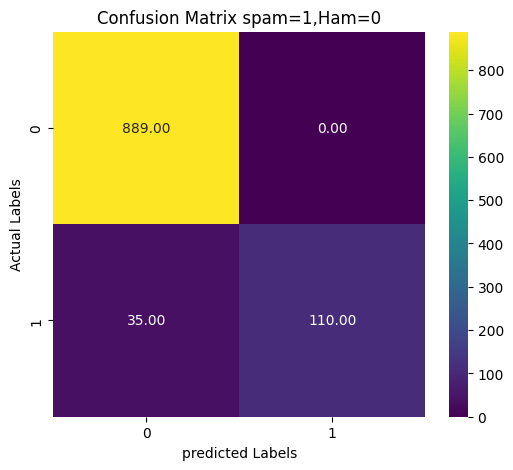

In [57]:
#Make a Confusion Matrix
conf=confusion_matrix(y_test,y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(conf,annot=True,fmt='.2f',cmap='viridis')
plt.xlabel('predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix spam=1,Ham=0')

plt.show()

In [58]:
# Cross Validation

In [60]:

stkf=StratifiedKFold(n_splits=10)
scores=cross_val_score(model,vector_data,y,cv=stkf,scoring='accuracy',n_jobs=-1)
#see the Accuracy of Cross Validation
print("Mean Accuracy of Cross Validation =",scores.mean())

Mean Accuracy of Cross Validation = 0.964597109141889


In [61]:
#see classification report 
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       1.00      0.76      0.86       145

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.96      1034



## Save The Model

In [62]:
joblib.dump(model,"NB_sms_classifier.joblib")

['NB_sms_classifier.joblib']